### Mohamed YOUSSFI, ENSET, UH2C

<img src="rag.png">

In [4]:
from PIL import Image
import glob
import tqdm as notebook_tqdm

In [7]:
image_list = []
for file_name in glob.glob("vehicules/*.jpg"):
    image = Image.open(file_name)
    image_list.append(image)

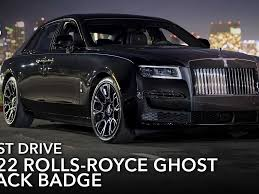

In [9]:
display(image_list[1])

In [10]:
import chromadb
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [13]:
chromadb_client = chromadb.PersistentClient(path="vehicles-store-vdb")
image_loader = ImageLoader()
image_embedding_model = OpenCLIPEmbeddingFunction()
chromadb_vdb = chromadb_client.get_or_create_collection(
    name="vehicules", 
    data_loader= image_loader, 
    embedding_function=image_embedding_model
    )

/Users/mohamedyoussfi/Documents/Generative AI/Ap-MM-RAG/venv/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint 

In [16]:
import os
images_ids = []
images_uris = []
images_folder = "vehicules"
for index, image_name in enumerate(sorted(os.listdir(images_folder))):
    if(image_name.endswith(".jpg")):
        image_path = os.path.join(images_folder, image_name)
        images_ids.append(str(index))
        images_uris.append(image_path)

In [17]:
print(images_ids[0:5])
print(images_uris[0:5])

['0', '1', '2', '3', '4']
['vehicules/1.jpg', 'vehicules/10.jpg', 'vehicules/100.jpg', 'vehicules/11.jpg', 'vehicules/12.jpg']


<table>
  <tr>
    <td><img src="clip.webp"></td>
    <td><img src="clip2.webp"></td>
  </tr>
</tables>

In [18]:
chromadb_vdb.add(ids=images_ids, uris= images_uris)

In [19]:
chromadb_vdb.count()

107

In [26]:
results = chromadb_vdb.query(query_texts=['anciennes voitures de couleur rouge'], n_results=4, include=['uris','distances'])

In [27]:
results

{'ids': [['106', '26', '27', '23']],
 'distances': [[1.530839308718213,
   1.5975937843322754,
   1.6093745231628418,
   1.6119608879089355]],
 'metadatas': None,
 'embeddings': None,
 'documents': None,
 'uris': [['vehicules/99.jpg',
   'vehicules/154.jpg',
   'vehicules/156.jpg',
   'vehicules/151.jpg']],
 'data': None,
 'included': ['uris', 'distances']}

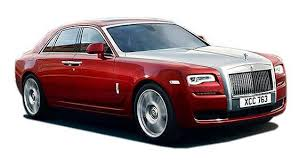

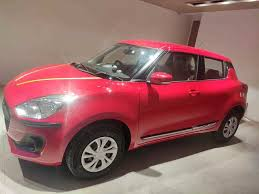

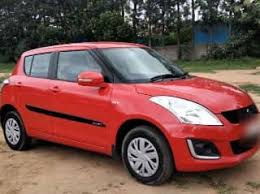

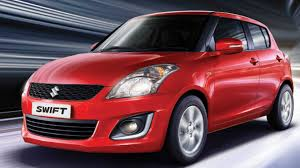

In [28]:
for image in results['uris'][0]:
    display(Image.open(image))

In [43]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import base64
from IPython.display import Markdown

In [30]:
OPENAI_API_KEY="...."

In [31]:
gpt_4o_model = ChatOpenAI(model="gpt-4o", temperature=0.0, api_key=OPENAI_API_KEY)
parser = StrOutputParser()
image_prompt = ChatPromptTemplate.from_messages(
    [
        ("system","{system_message}"),
        ("user", [
            {"type":"text", "text": "{user_question}"},
            {"type":"image_url", "image_url": "data:image/jpeg;base64,{image_data1}"},
            {"type":"image_url", "image_url": "data:image/jpeg;base64,{image_data2}"},
        ])
    ]
)
vision_chain = image_prompt|gpt_4o_model|parser

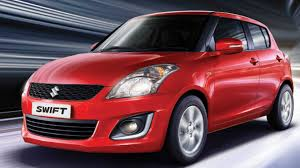

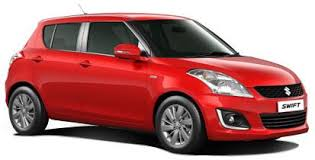

In [47]:
prompt_input ={}
system_message = """
Answer the user's question using the given images context with references to the parts of the images provided.
User Markdown to give your answer
"""

user_question = "donne moi la description des deux anciennes voitures de couleur rouge"

results = chromadb_vdb.query(query_texts=[user_question], n_results=2, include=['uris','distances'])

image_path1 = results['uris'][0][0]
image_path2 = results['uris'][0][1]
display(Image.open(image_path1))
display(Image.open(image_path2))
with open(image_path1,'rb') as image_file:
    image_data1 = image_file.read()
with open(image_path2,'rb') as image_file:
    image_data2 = image_file.read()    

prompt_input["system_message"]= system_message
prompt_input["user_question"]= user_question
prompt_input["image_data1"]= base64.b64encode(image_data1).decode('utf-8')
prompt_input["image_data2"]= base64.b64encode(image_data2).decode('utf-8')


In [48]:
response = vision_chain.invoke(prompt_input)
display(Markdown(response))

Les deux images montrent des voitures de couleur rouge, de marque Suzuki, modèle Swift. Voici une description détaillée de chaque voiture :

1. **Première voiture (Image 1) :**
   - **Couleur :** Rouge vif.
   - **Marque :** Suzuki.
   - **Modèle :** Swift.
   - **Caractéristiques extérieures :**
     - La voiture est un modèle à cinq portes.
     - Les phares avant sont de forme allongée et légèrement inclinés vers l'arrière.
     - La calandre est noire avec le logo Suzuki au centre.
     - Les jantes sont en alliage et de couleur argentée.
     - Les rétroviseurs latéraux sont de la même couleur que la carrosserie.
     - Le pare-chocs avant est équipé de feux antibrouillard.

2. **Deuxième voiture (Image 2) :**
   - **Couleur :** Rouge vif.
   - **Marque :** Suzuki.
   - **Modèle :** Swift.
   - **Caractéristiques extérieures :**
     - La voiture est également un modèle à cinq portes.
     - Les phares avant sont similaires à ceux de la première voiture, allongés et inclinés vers l'arrière.
     - La calandre est noire avec le logo Suzuki au centre.
     - Les jantes sont en alliage et de couleur argentée.
     - Les rétroviseurs latéraux sont de la même couleur que la carrosserie.
     - Le pare-chocs avant est équipé de feux antibrouillard.

Les deux voitures semblent être du même modèle et de la même génération, avec des caractéristiques très similaires.

In [33]:
results

{'ids': [['106', '26']],
 'distances': [[1.530839308718213, 1.5975937843322754]],
 'metadatas': None,
 'embeddings': None,
 'documents': None,
 'uris': [['vehicules/99.jpg', 'vehicules/154.jpg']],
 'data': None,
 'included': ['uris', 'distances']}